# Monte Carlo Control

Monte Carlo methods learns by estimating value functions and disconvering optimal policies.

MC methods require only experiences and do not require complete knowledge of the environment.

MC methods are based on averaging complete returns (as opposed to methods that learn from partial returns).

## Generalized Policy Iteration

Policy iteration consists of two simultaneous, interacting processes.

* policy evaluation
  * making the value function consistent with the current policy
* policy improvement
  * making the policy greedy with respect to the current value function

## Monte Carlo Development

* Monte Carlo Prediction (uses state-value function)
* Monte Carlo Estimation of Action Values
* Monte Carlo Control with Exploring Starts
* Monte Carlo Control without Exploring Starts
* Off-policy Prediction via Importance Sampling
  * two separate policies
    * target policy
    * behavior policy
* Incremental Implementation
* Off-policy Monte Carlo Control
* Discounting-aware Importance Sampling
* Per-decision Importance Sampling

In [28]:
%load_ext autoreload
%autoreload 2

import numpy as np
import gym
import plot_utils

env = gym.make('Blackjack-v0')

In [4]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


## Monte Carlo Prediction

Learns the state-value function for a given policy. Estimates $v_\pi(s)$, the value of a state $s$ under policy $\pi$, given a set of episodes obtained by following \pi and passing through $s$.

* _first-visit MC method_ estimates $v_\pi(s)$ as the average of the returns following **first visits** to $s$.
* _every-visit MC method_ estimates $v_\pi(s)$ as the average of the returns following **all visits** to $s$.


* a _visit_ to $s$: each occurence of state $s$ in an episode
* _first visit_ to $s$: the first time state $s$ is visited in an episode

Both MC methods are very similar but have slightly different theoretical properties.

Every-visit MC extends more naturally to function approximation and eligibility traces.

In [31]:
from collections import defaultdict

def first_visit_monte_carlo_prediction(
        policy, env, num_episodes, discount_rate):
    """Estimates the state-value function for a given policy
    
    Args:
      policy: a policy of which state-value function is estimated
      env: a gym environment to be explored
  
    Returns:
      a dict of (state -> value)
    """
    # The action space must be discrete for monte carlo methods.
    n_actions = env.action_space.n
    
    # state-value table V
    state_values = defaultdict(int)
    
    # a dict (state -> sum(returns))
    return_sum = defaultdict(int)
    
    # a dict (state -> # of returns)
    n_returns = defaultdict(int)
    
    # So that state-value function should converge, we need to run
    # a infinitely large number of episodes.
    for _ in range(num_episodes):
        
        episode = generate_episode(env, policy)
        
        # returns after _state_
        state_returns = defaultdict(int)

        # Store the accumulated rewards
        return_ = 0
        
        # Accumulate rewards in reverse
        for state, action, reward in reversed(episode):
            
            # Discount the future rewards
            return_ = discount_rate * return_ + reward
            
            # Overwrite the previous value since the last value in reverse
            # is the return of the first visit to state
            state_returns[state] = return_
            
        for state, return_ in state_returns.items():
            # Add up all returns of first visits to each state
            return_sum[state] += return_
            # Increase the counter of returns
            n_returns[state] += 1
            # State-value is the average of the returns of first-visits to
            # each state
            state_values[state] = return_sum[state] / n_returns[state]
            
    return state_values

def generate_episode(env, policy):
    """Generates an episode following _policy_ in environment _env_
    
    Returns:
        episode: a list of (state, action, reward)
    """
    episode = []
    
    # Start a new episode
    prev_state = env.reset()
    done = False
    
    while not done:
        action = policy(prev_state)
        state, reward, done, _ = env.step(action)
        episode.append((prev_state, action, reward))
        prev_state = state
    
    return episode


[((15, 10, False), 1, -1)]
[((12, 1, False), 0, -1.0)]
[((20, 5, False), 1, -1)]


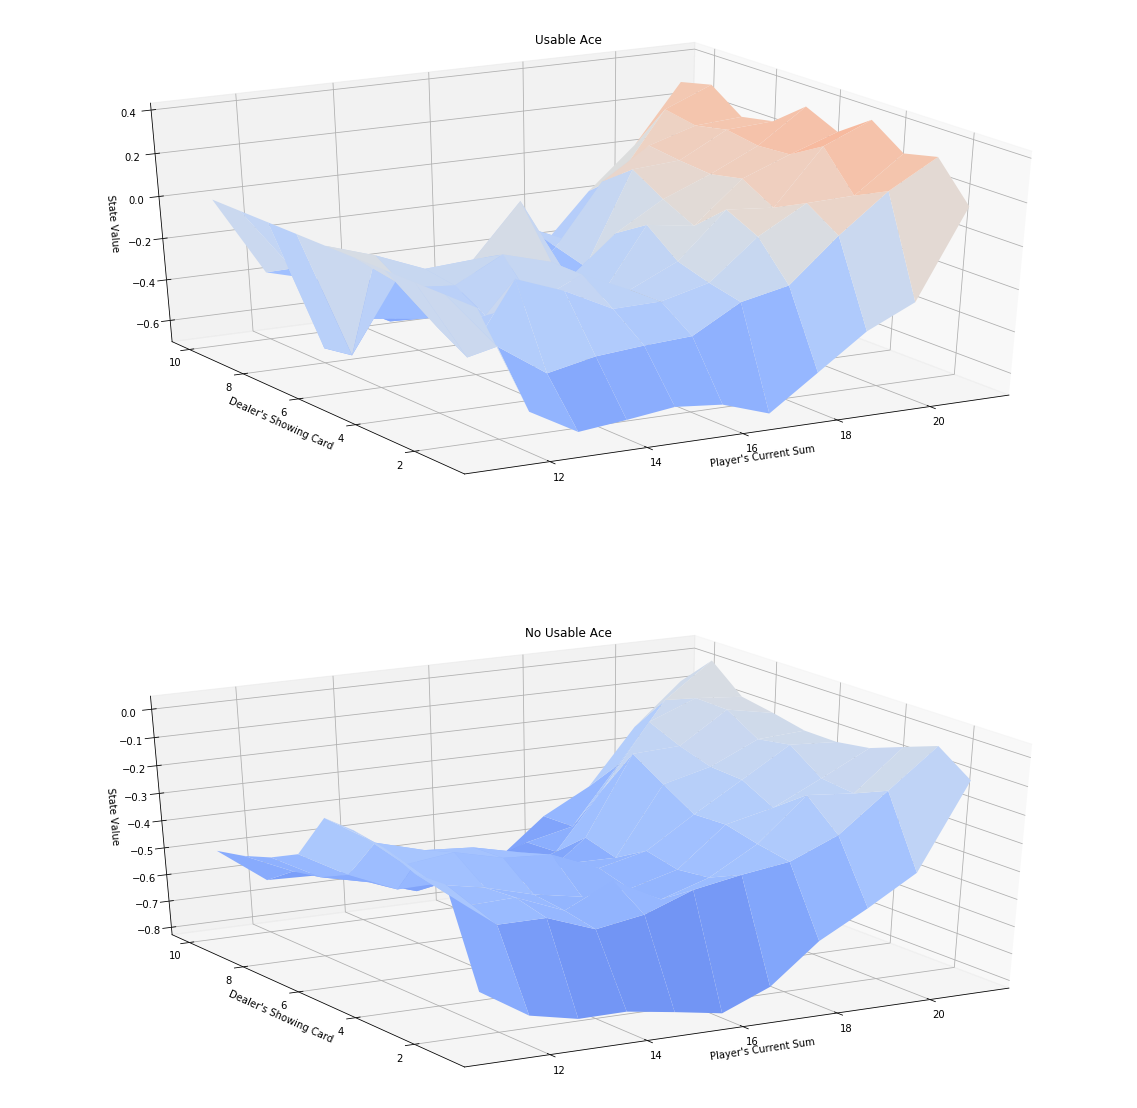

In [30]:
env = gym.make('Blackjack-v0')
policy = lambda _state: env.action_space.sample()
for _ in range(3):
    print(generate_episode(env, policy))

v = first_visit_monte_carlo_prediction(
    env=env, policy=policy, num_episodes=100000, discount_rate=1.)
plot_utils.plot_blackjack_values(v)

## Monte Carlo Estimation of Action Values

One of the primary goals for Monte Carlo methods is to estimate action-value function $q_*(s,a)$. Without a model, state values alone are not sufficient to determine a policy since without a model, we cannot know which action leads to the most valuable state.

### Maintaining Exploration Problem

To make MC methods converge to the true expected values, every state-action pair must be visited large enough number of times. A deterministic policy visits only one action from each state leaving other actions not evaluated.

_Exploring starts_ guarantees that all state-action pairs will be visited an infinite number of times in the limit of an infinite number of episodes.

_Stochastic policies_ with a nonzero probability of selecting all actions in each state also guarantees the same.

$
\DeclareMathOperator*{\argmax}{\mathop{\rm arg\,max}}
$

## Monte Carlo with Exploring Starts

The basic monte carlo control algorithm.

According to the idea of generalized policy iteration (GPI), Monte Carlo Control methods maintain both an approximate policy and an approximate value function and perform alternating complete steps of policy evaluation and policy improvement.

Policy improvement is done by making the policy greedy with respect to the current value function.

For any action-value function q, the corresponding greey policy is the one that, for each $s in S$, deterministically chooses an action with maximal action-value.

\begin{equation}
\pi(s) \doteq \argmax_a q(s, a)
\end{equation}

Then the policy improvement theorem applies to $\pi_k$ and $\pi_{k+1}$ because, for all $s \in S$,

\begin{align*}
q_{\pi_k}(s, \pi_{k+1}(s)) & = q_{\pi_k}(s, \argmax_a q_{\pi_k}(s, a)) \\
                           & = \max_a q_{\pi_k}(s, a) \\
                           & \geq q_{\pi_k}(s, \pi_k(s)) \\
                           & \geq v_{\pi_k}(s).
\end{align*}

Two unlikely assumptions made to guarantee the above:

  * The episodes have exploring starts.
  * Policy evaluation could be done with an infinite number of episodes.
  
To avoid the second assumption,

  * Hold firm to the idea of approximating $q_{\pi_k}$ in each policy evaluation. Take sufficient steps during each policy evaluation to assure that the bounds on the magnitude and probability of error in the estimates are sufficiently small. Far too many episodes are required to be useful in practice.
  * Not try to complete policy evaluation before returning to policy improvement. Move the value function toward $q_{\pi_k}$ on each evaluation step, but we do not expect to actually get close except over many steps. Monte Carlo methods alternate evaluation and improvement on an episode-by-episode basis.

In [ ]:
def monte_carlo_control_es(num_episodes, epsilon_gen):
    """Monte Carlo Control
    
    Args:
      num_episodes: the number of episodes for which the policy is
          optimized
      epsilon_gen: 
    """
    pass

## Monte Carlo Control without Exploring Starts

How can we avoid the unlikely assumption of exploring starts?

### On-policy vs Off-policy

* *On-policy* methods attempt to evaluate or improve the policy that is
  used to make decisions
* *Off-policy* methods attempt to evaluate or improve a policy different from
   that used to generate the data

### $\epsilon$-*greedy* policy

In on-policy control methods the policy is generally *soft* but gradually shifted closer to a deterministic optimal policy.

> A policy $\pi$ is *soft* when $\pi(a|s) >0$ for all $s \in S$ and all $a \in A$.

A $\epsilon$-*greedy* policy, most of time, chooses an action that has maximal estimated action value but with probability $\epsilon$ instead selects an action at random.

\begin{equation}
\pi(a|s) =
    \begin{cases}
        1 - \epsilon + \frac{\epsilon}{|A(s)|} & \text{when } a = argmax_{a' \in A(s)} Q(s,a')\\
        \frac{\epsilon}{|A(s)|} & \text{otherwise }
    \end{cases}
\end{equation}

That any $\epsilon$-greedy policy with respect to $q_\pi$ is an improvement over any $\epsilon$-soft policy $\pi$ is assured by the policy improvement theorem.

\begin{align}
q_\pi(s, \pi'(s))
    &= \sum_{a} \pi'(a|s) q_\pi(s,a) \\
    &= \frac{\epsilon}{|A(s)|} \sum_a q_\pi(s,a)
            + (1 - \epsilon) \max_a q_\pi(s,a) \\
    &\geq \frac{\epsilon}{|A(s)|} \sum_a q_\pi(s,a)
            + (1 - \epsilon) \sum_a 
                \frac{\pi(a|s) - \frac{\epsilon}{|A(S)|}}{1 - \epsilon}
                q_\pi(s,a) \\
    &= \frac{\epsilon}{|A(s)|} \sum_a q_\pi(s,a)
       - \frac{\epsilon}{|A(S)|} \sum_a q_\pi(s,a) 
       + \sum_a \pi(a|s) q_\pi(s,a) \\
    &= v_\pi(s)
\end{align}

### Policy Improvement Theorem

\begin{equation}
\pi' \geq \pi \equiv
v_{\pi'}(s) \geq v_{\pi}(s) \text{, for all } s \in S
\end{equation}

In [21]:
import random
import math

def monte_carlo_control_on_policy_first_visit(
        env, num_episodes, epsilon, discount_rate):
    def make_egreedy(q, epsilon):
        def egreedy(state):
            if random.random() > epsilon:
                action = np.argmax(q(state))
            else:
                action = env.action_space.sample()
            return action
        return egreedy
    
    # The number of possible actions
    n_actions = env.action_space.n
    
    # The action-value table q (state -> [action-value])
    q = defaultdict(lambda: np.zeros(n_actions))
    
    # ((state, action) -> sum-of-returns)
    q_return_sum = defaultdict(float)
    
    # ((state, action) -> the-number-of-first-visits)
    q_visits = defaultdict(int)
    
    # An initial e-greedy policy
    policy = make_egreedy(lambda s: q[s], epsilon)
    
    for i_episode in range(num_episodes):
        episode = generate_episode(env, policy)
        if int(math.log10(i_episode + 1)) == math.log10(i_episode + 1):
            print(i_episode, episode)
        
        # An accumulated return G
        return_ = 0
        
        # a dict ((state, action) -> return)
        q_episode = defaultdict(float)
        for state, action, reward in reversed(episode):
            return_ = discount_rate * return_ + reward
            q_episode[state, action] = return_
            
        for (state, action), return_ in q_episode.items():
            q_return_sum[state, action] += return_
            q_visits[state, action] += 1
            q[state][action] = \
                q_return_sum[state, action] / q_visits[state, action]
            
        policy = make_egreedy(lambda state: q[state], epsilon)
    
    return policy, q

In [22]:
env = gym.make('Blackjack-v0')

policy, q = monte_carlo_control_on_policy_first_visit(env, 10**5, epsilon=0.2, discount_rate=0.99)

0 [((19, 7, False), 0, 1.0)]
9 [((16, 10, True), 0, -1.0)]
99 [((13, 10, False), 1, 0), ((17, 10, False), 1, -1)]
999 [((14, 3, True), 0, -1.0)]
9999 [((15, 2, False), 1, -1)]
99999 [((17, 10, True), 1, 0), ((15, 10, False), 0, -1.0)]


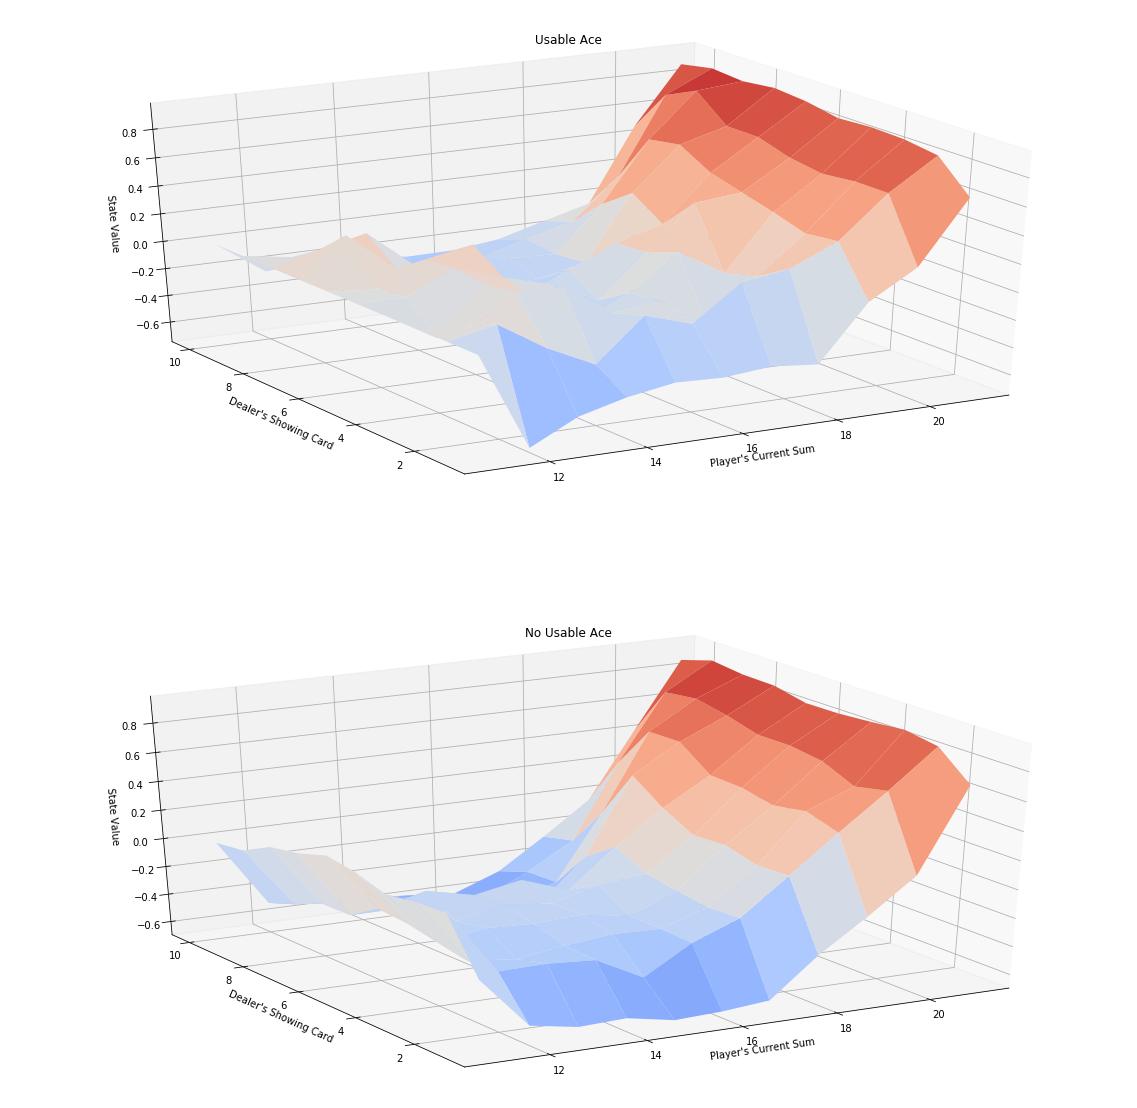

In [32]:
v = dict([(state, np.max(action_values)) for state, action_values in q.items()])
plot_utils.plot_blackjack_values(v)